# Latent Dirichlet Allocation

In this final assignment, you will implement LDA and try it out on a corpus. Be sure to start work on this assignment early, because running your code will take some time. A full run of my implementation took about four hours. Consider running your code on smaller subcorpora during debugging.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Data loading

Try your Gibbs sampler on the corpus of 2000 movie reviews from Pang & Lee (2004), available on Classroom. The first line of the file specifies the number of documents. Then each subsequent line is one document, with the tokens separated by whitespace. I generated the file on Classroom from the original movie reviews by tokenizing them and then removing punctuation and stopwords, so you get nicer topics.

In [3]:
! pip install pyLDAvis
! pip install wget

In [4]:
FORCE_RETRAIN_MODEL = False
PATH_TO_TRAINED_MODEL = '20_topics_500_iters_full_vocab.json'

NUM_OF_TOPICS = 20
NUM_OF_ITERATIONS = 500
# -1 is default for saving only after full train
SAVE_EVERY_N_ITERATIONS = 100

SOURCE_DATA_FILENAME = 'movies-pp.txt' # 'movies-pp.txt', 'belapan_lda_be.txt', 'belapan_lda_ru.txt'
SOLUTION_FILENAME = 'solution.py'

In [5]:
import os
import wget
import pyLDAvis

path_to_git_folder = 'https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Computational_Linguistics/HW6_LDA'

if not os.path.isfile(SOLUTION_FILENAME):
    wget.download(f'{path_to_git_folder}/{SOLUTION_FILENAME}')

if not os.path.isfile(SOURCE_DATA_FILENAME):
    wget.download(f'{path_to_git_folder}/data/{SOURCE_DATA_FILENAME}')

if FORCE_RETRAIN_MODEL is False and not os.path.isfile(PATH_TO_TRAINED_MODEL):
    wget.download(f'{path_to_git_folder}/models/{PATH_TO_TRAINED_MODEL}')

In [16]:
from solution import DataHelper

data_helper = DataHelper(SOURCE_DATA_FILENAME, NUM_OF_TOPICS)

print(data_helper.NUM_OF_DOCS, data_helper.VOCAB_SIZE, data_helper.CORPUS_SIZE)

2000 46517 698784


In [19]:
# I wanted to check topic distribution prior to all training
# We can see that it is almost uniform
movies_vis_data = data_helper.get_lda_vis_data()
pyLDAvis.display(movies_vis_data)

## Gibbs sampler

Implement a Gibbs sampler which resamples a topic for each word in the corpus according to the probability distribution in formula [5] of [Griffiths & Steyvers (2004)](https://www.pnas.org/content/101/suppl_1/5228). Initialize the topic assignments by choosing a topic uniformly at random for each token in the corpus. You can also refer to [Darling tutorial](https://u.cs.biu.ac.il/~89-680/darling-lda.pdf) for details of implementation.

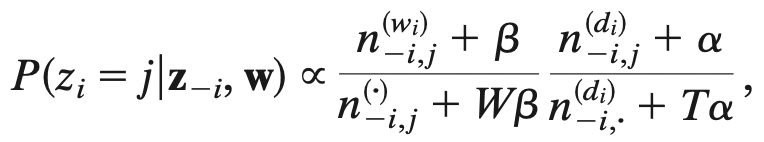

[35066, 35230, 34886, 35018, 34960, 34637, 35159, 34882, 34888, 34988, 34871, 34931, 34760, 34969, 34618, 35133, 34642, 35180, 34950, 35016]


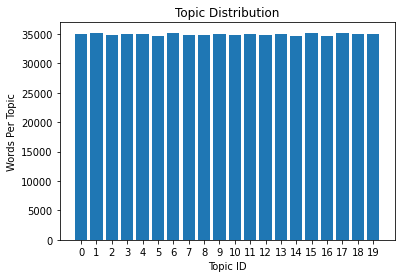

In [7]:
from solution import plot_topic_distribution

print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

Algorithm
```
        run for NUM_OF_ITERATIONS (hyperparam)
            for each word_document pair in corpus
                get current topic
                decrease all respective counts:
                    - general count of this topic;
                    - count of this topic for specific word;
                    - count of this topic in document;
                run loop over topics count K
                    re-evaluate word_to_topic sampling probabilites
                choose new topic for the word based on weights obtained above
                increase all respective counts
```

Apply Gibbs sample to full corpus:

In [8]:
from solution import GibbsSampler

if FORCE_RETRAIN_MODEL:
    gibbs_sampler = GibbsSampler(data_helper)
    data_helper = gibbs_sampler.train(NUM_OF_ITERATIONS, iterations_to_save=SAVE_EVERY_N_ITERATIONS)
    path_to_trained_helper = data_helper.export_trained_helper()
else:
    data_helper = DataHelper.import_trained_helper(
        path_to_model_file=PATH_TO_TRAINED_MODEL,
        base_data_helper=data_helper,
    )
    data_helper.run_consistency_tests()

I have experimented with 10 and 20 topic and also with vocab filtering. Vocab filtering included removing words that appearing in less than 10 documents (very rare and, possibly, not very characteristic/informative) and very common words appering in more than half of documents (words like 'film', 'movie' which appear in almost every review and, hence, too common to build specific topic on top of them).

Time of iteration:<br>
1) Full vocab (\~47k tokens), 20 topics: \~20sec<br>
2) Filtered vocab (\~8k tokens), 20 topics: \~15sec<br>
3) Filtered vocab (\~8k tokens), 10 topics: \~11.5sec<br>

In [9]:
data_helper.print_top_words_for_all_topics()

Topic ID: 1
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 2
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 3
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 4
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'character']
Topic ID: 5
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 6
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 7
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 8
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'much']
Topic ID: 9
Top-10 words: ['film', 'movie', 'one', 'like', 'even', 'good', 'time', 'would', 'story', 'character']
Topic ID:

Even after filtering out very common words and 500 iterations I had almost the same top-10 topic wordlists. Hence, we need some advanced to analyse topic distinction. I have decided to use [pyLDAvis](!https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) and set $\lambda$ (relevance metric parameter) to 0.2 to check unique words for each topic. Also, PCA plot helps to understand whether we learned some different topics or not.

In [15]:
movies_vis_data = data_helper.get_lda_vis_data()
pyLDAvis.display(movies_vis_data)

In [29]:
def load_model_and_get_vis_data(model_name: str):
    """Loads model from json file and runs pyLDAvis."""
    if FORCE_RETRAIN_MODEL is False and not os.path.isfile(model_name):
        wget.download(f'{path_to_git_folder}/models/{model_name}')

    loaded_data_helper = DataHelper.import_trained_helper(
        path_to_model_file=model_name,
        path_to_source_data=SOURCE_DATA_FILENAME,
    )
    loaded_data_helper.run_consistency_tests()

    print(loaded_data_helper.NUM_OF_DOCS, loaded_data_helper.VOCAB_SIZE, loaded_data_helper.CORPUS_SIZE)
    return loaded_data_helper.get_lda_vis_data()

In [30]:
# Visualise model after 100 iterations
vis_data = load_model_and_get_vis_data('20_topics_100_iters_full_vocab.json')
pyLDAvis.display(vis_data)

2000 46517 698784


In [31]:
# Visualise model with smaller vocab after full training
vis_data = load_model_and_get_vis_data('20_topics_500_iters_small_vocab.json')
pyLDAvis.display(vis_data)

2000 7944 542286


In [32]:
# Visualise model with smaller vocab after full training
vis_data = load_model_and_get_vis_data('10_topics_500_iters_small_vocab.json')
pyLDAvis.display(vis_data)

2000 7944 542286


## Conclusion
Whereas LDA topic modeling definitely learns something (resulting topics have different PCA representation), I cannot distinguish topic after analysis. Without making $\lambda$=0.21 most frequent words are dominating in each topic, with word-lists become quite random, to my mind.

However, I cannot say that I find topic semantically very coherent. I see several ways to explain it:<br>
1) Movie corpus is homogeneous, so possibly news data can show larger variety in topics<br>
2) Data preprocessing step can exclude verbs, do stemming, lemmatization, so we can reduce noise in data<br>
3) Hyperparameters tuning can drastically affect final distribution<br>

Or there is just a bug in my code ;)

Speaking about hyperparameters, I see the following patterns:<br>
1) Topics are definitely getting reassigned and distribution changes over iterations (compare 100 iterations and 500). However, for full_corpus topics remain very close in PCA space. Possibly, it is due to most common words unfiltered.<br>
2) Small vocab brings better spacial distinction of topics.<br>
3) Decreasing number of topics (20->10) unsurprisingly makes topics bigger (larger diameter of circles).<br>

## Extra credit

- Use Numpy to speed up the calculations;
- try your system on other corpora; 
- experiment with different strategies for initializing the topic assignments (e.g., give the same topic to all words of the same document);
- use a bit of supervised information (e.g., fix the topic assignments for specific words that you know should belong to that topic, and do not allow the sampler to change them).


Uncomment code below if you want to recreate Belarusian/Russian files with more/less documents.
Please be careful, since big (~110mb) source files will be downloaded here.

In [11]:
# ! pip install gsutil

# raw_bel_filepath = "Corpus_Bel.txt_tok.txt_true.txt"
# raw_rus_filepath = "Corpus_Rus.txt_tok.txt_true.txt"

# if not os.path.isfile(raw_bel_filepath):
#     !gsutil -m cp -r "gs://mytranslator-298419-vcm/RuBeCorpus_BelapanNews/Separate Corpuses/FullCorpus/$raw_bel_filepath" .
    
# if not os.path.isfile(raw_rus_filepath):
#     !gsutil -m cp -r "gs://mytranslator-298419-vcm/RuBeCorpus_BelapanNews/Separate Corpuses/FullCorpus/$raw_rus_filepath" .

# def convert_corpus_to_lda_format(source_filepath: str, lang: str, size_of_corpus: int = 20000) -> str:
#     target_file_name = f'belapan_lda_{lang}.txt'
#     with open(source_filepath, 'r') as input_f, open(target_file_name, 'w') as output_f:
#         output_f.write(f"{size_of_corpus}\n")
#         for i, line in enumerate(input_f):
#             if i == size_of_corpus:
#                 break
#             output_f.write(line)
    
#     return target_file_name

# lda_bel_file = convert_corpus_to_lda_format(raw_bel_filepath, lang='be')
# lda_ru_file = convert_corpus_to_lda_format(raw_rus_filepath, lang='ru')

# print(lda_bel_file, lda_ru_file)

In [12]:
BEL_SOURCE_FILENAME = 'belapan_lda_be.txt'
BEL_TRAINED_MODEL = '10_topics_100_iters_bel_model.json'

if not os.path.isfile(BEL_SOURCE_FILENAME):
    wget.download(f'{path_to_git_folder}/data/{BEL_SOURCE_FILENAME}')

if not os.path.isfile(BEL_TRAINED_MODEL):
    wget.download(f'{path_to_git_folder}/models/{BEL_TRAINED_MODEL}')

In [13]:
bel_data_helper = DataHelper.import_trained_helper(
    path_to_model_file=BEL_TRAINED_MODEL,
    path_to_source_data=BEL_SOURCE_FILENAME,
)
bel_data_helper.run_consistency_tests()

print(bel_data_helper.NUM_OF_DOCS, bel_data_helper.VOCAB_SIZE, bel_data_helper.CORPUS_SIZE)
bel_vis_data = bel_data_helper.get_lda_vis_data()
pyLDAvis.display(bel_vis_data)

20000 44254 447300
